# Find Cosine Similarity Between Artists

### TODO

* Maybe: Latent semantic analysis
* Tune and evaluate hyperparameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

%matplotlib inline

In [2]:
tracks_by_artist = pd.read_csv("./data/complete_tracks_with_lyrics.csv")
# Decided to tokenise text as part of the TfidfVectorizer initialisation for better consistency
tracks_by_artist = tracks_by_artist[["artist", "album", "track", "lyrics"]]

In [3]:
tracks_by_artist.head()

,artist,album,track,lyrics
0,BROCKHAMPTON,iridescence,WEIGHT,[Verse 1: Kevin Abstact]\nThey split my world ...
1,BROCKHAMPTON,iridescence,VIVID,"[Intro: Matt Champion]\n""Yo, get—[censored]—tu..."
2,BROCKHAMPTON,iridescence,TAPE,"[Verse 1: Kevin Abstract]\nI can barely rap, I..."
3,BROCKHAMPTON,Saturation III,STAINS,[Verse 1: Ameer Vann]\nI spent like a year and...
4,BROCKHAMPTON,iridescence,DISTRICT,"[Intro]\n""I'm Sammy Jo, and my favorite colors..."


In [6]:
tracks_by_artist["artist"].unique()

array(['BROCKHAMPTON', 'Drake', 'Eminem', 'Future', 'Gucci Mane',
       'J. Cole', 'Kendrick Lamar', 'Kevin Gates', 'Kodak Black',
       'Lil Uzi Vert', 'Lil Yachty', 'Migos', 'Moneybagg Yo', 'NF',
       'Post Malone', 'Russ', 'Wiz Khalifa', 'YoungBoy Never Broke Again'],
      dtype=object)

In [4]:
# Helper functions

def tokenizer(raw_lyrics):
    # Some choices here are specific to the format of Genius lyrics, want to remove non-vocalised 
    # text in square brackets, and other text not part of the main song body such as adlibs in 
    # round brackets
    raw_lyrics = re.sub("([\(\[].*?[\)\]])|([^\w\d'\s]+)", "", raw_lyrics)
    raw_lyrics = re.sub("\n", " ", raw_lyrics)
    # Ignore case    
    raw_lyrics = raw_lyrics.lower()
    word_list = raw_lyrics.split()

    return word_list

def normalise_vector(vector):
    return vector / np.sqrt(np.dot(vector,vector))

def add_vectors(vectors):
    return normalise_vector(np.sum(vectors, axis=0))

def ranked_words_by_weighting(vector, top_n):
    return sorted(zip(vectorizer.get_feature_names(), vector), key=lambda x: x[1], reverse=True)[:top_n]

def most_representative_songs(vector, tracks_by_artist, top_n):
    df = tracks_by_artist.copy()
    df["dist"] = df["normalised_vectors"].apply(lambda target: cosine(vector, target))
    df.sort_values("dist", inplace=True)
    return df[:top_n]

def most_similar_artists(vector, artist_vectors, top_n):
    df = artist_vectors.reset_index().copy()
    df["dist"] = df["normalised_vectors"].apply(lambda target: cosine(vector, target))
    df.sort_values("dist", inplace=True)
    return df[1:top_n+1]

In [5]:
hyperparamters = [
    {"max_df": 1.0, "min_df": 1}, # i.e. default values
    {"max_df": 1.0, "min_df": 0.001},
    {"max_df": 0.7, "min_df": 1},
    {"max_df": 0.7, "min_df": 0.001}
]

In [6]:
for hp in hyperparamters:

    vectorizer = TfidfVectorizer(
        stop_words=ENGLISH_STOP_WORDS,
        lowercase=False,
        max_df=hp["max_df"],
        min_df=hp["min_df"],
        ngram_range=(1,3),
        tokenizer=tokenizer,
        norm=None
    )
    
    tracks_by_artist_copy = tracks_by_artist.copy()
    tracks_by_artist_copy["unnormalised_vectors"] = list(vectorizer.fit_transform(tracks_by_artist_copy["lyrics"].values).toarray())
    tracks_by_artist_copy["normalised_vectors"] = tracks_by_artist_copy["unnormalised_vectors"].apply(normalise_vector)
    # Found case where unnormalised vector is zero vector, in this case an Eminem skit
    tracks_by_artist_copy = tracks_by_artist_copy[tracks_by_artist_copy["unnormalised_vectors"].apply(sum) != 0]

    artist_vectors = (
        tracks_by_artist_copy
        .groupby("artist")
        .normalised_vectors
        .apply(add_vectors)
    )
    
    for artist in artist_vectors.index.values:
        artist_vector = artist_vectors.ix[artist]
        if artist == "Lil Uzi Vert": # Example to track for now
            print("max_df=", hp["max_df"], "min_df=", hp["min_df"])
            print(artist)
            print("Most important words")
            print(ranked_words_by_weighting(artist_vector, 3))
            print("Most representative songs")
            print(most_representative_songs(artist_vector, tracks_by_artist_copy, 3)[["artist", "album", "track", "dist"]])
            print("Most similar artsts")
            print(most_similar_artists(artist_vector, artist_vectors, 3)[["artist", "dist"]])
            print('--------------------\n')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


max_df= 1.0 min_df= 1
Lil Uzi Vert
Most important words
[('yeah', 0.14462177358038378), ('diamonds', 0.1357562179656025), ('yah', 0.12641213771053364)]
Most representative songs
           artist          album          track      dist
189  Lil Uzi Vert  Luv Is Rage 2  XO TOUR Llif3  0.577473
198  Lil Uzi Vert  Luv Is Rage 2              X  0.577473
180  Lil Uzi Vert  Luv Is Rage 2    Pretty Mami  0.736155
Most similar artsts
         artist      dist
13           NF  0.802808
8   Kodak Black  0.803255
15         Russ  0.807117
--------------------

max_df= 1.0 min_df= 0.001
Lil Uzi Vert
Most important words
[('yeah', 0.14462177358038378), ('diamonds', 0.1357562179656025), ('yah', 0.12641213771053364)]
Most representative songs
           artist          album          track      dist
189  Lil Uzi Vert  Luv Is Rage 2  XO TOUR Llif3  0.577473
198  Lil Uzi Vert  Luv Is Rage 2              X  0.577473
180  Lil Uzi Vert  Luv Is Rage 2    Pretty Mami  0.736155
Most similar artsts
         a

In [5]:
# Clustering analysis
vectorizer = TfidfVectorizer(
    stop_words=ENGLISH_STOP_WORDS,
    lowercase=False,
    ngram_range=(1,3),
    tokenizer=tokenizer,
    norm=None
)

tracks_by_artist_copy = tracks_by_artist.copy()
tracks_by_artist_copy["unnormalised_vectors"] = list(vectorizer.fit_transform(tracks_by_artist_copy["lyrics"].values).toarray())
tracks_by_artist_copy["normalised_vectors"] = tracks_by_artist_copy["unnormalised_vectors"].apply(normalise_vector)
# Found case where unnormalised vector is zero vector, in this case an Eminem skit
tracks_by_artist_copy = tracks_by_artist_copy[tracks_by_artist_copy["unnormalised_vectors"].apply(sum) != 0]

artist_vectors = (
    tracks_by_artist_copy
    .groupby("artist")
    .normalised_vectors
    .apply(add_vectors)
)

In [9]:
artist_vectors.values.tolist()

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.       , 0.       , 0.       , ..., 0.0062102, 0.0062102,
        0.0062102]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.00496272, 0.00496272, 0.00496272, ..., 0.        , 0.        ,
        0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [49]:
from sklearn.cluster import KMeans

n_clusters = 9
data = tracks_by_artist_copy["normalised_vectors"].tolist()

model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=9, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [50]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(n_clusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print()

Top terms per cluster:
Cluster 0:
 i'm
 gucci
 head head
 nigga
 real
 way
 head head head
 million
 got
 goin' hard

Cluster 1:
 know
 i'm
 diamonds
 like
 just
 girl
 baby
 yah
 let
 can't

Cluster 2:
 i'm
 harley
 harley harley
 sellin' dope
 motivate
 ring
 harley harley harley
 motivate motivate
 whoaoh
 like

Cluster 3:
 ooh
 ooh ooh
 feel feel
 ooh ooh ooh
 yeah
 loaded loaded
 loaded
 feel feel feel
 loaded loaded loaded
 uh ooh

Cluster 4:
 i'm
 like
 don't
 ain't
 feel like
 feel
 know
 just
 wanna
 got

Cluster 5:
 bitch
 yeah
 nigga
 i'm
 got
 gang
 real
 ain't
 fuck
 niggas

Cluster 6:
 i'm
 nigga
 ain't
 don't
 niggas
 got
 fuck
 know
 gon'
 shit

Cluster 7:
 yeah
 i'm
 oh
 like
 don't
 know
 oh oh
 got
 right
 ain't

Cluster 8:
 love
 'cause
 la la
 la la la
 like
 la
 i'm
 you're
 quiet
 special



In [51]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
print(order_centroids)
print(model.labels_)
print(len(model.labels_))
# terms = vectorizer.get_feature_names()
# for i in range(n_clusters):
#     print("Cluster %d:" % i)
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind])
#     print()

Top terms per cluster:
[[ 55469  48571  50788 ...  43607  22199  75295]
 [ 64646  55469  27739 ...  61677  71966  66613]
 [ 55469  50135  50146 ...   7926  10131  28454]
 ...
 [ 55469  82972   3548 ...  72656  66174  86062]
 [132348  55469  85909 ... 125539  38712  66174]
 [ 74203    384  66174 ...  54199  12595  44550]]
[6 7 7 0 1 0 6 6 4 1 0 4 8 8 1 8 3 4 7 8 7 7 1 7 5 7 1 6 6 8 7 0 4 7 7 0 7
 7 7 5 7 8 8 8 8 8 8 7 2 7 8 8 7 5 6 8 7 4 7 4 1 8 7 0 1 7 7 7 5 7 6 1 1 7
 0 7 5 1 8 8 5 0 8 4 0 6 7 0 5 0 6 1 6 5 0 5 8 7 4 7 2 0 0 2 6 2 7 0 6 0 7
 0 6 6 5 7 6 7 5 6 7 6 6 4 0 8 7 5 6 5 0 5 0 7 8 2 8 1 6 3 8 6 4 6 4 5 6 6
 7 6 4 6 2 6 6 7 5 8 5 6 8 5 6 4 6 4 2 4 6 4 6 7 6 1 3 1 2 6 4 1 3 1 7 1 6
 7 7 1 7 6 7 4 5 1 1 5 0 7 7 3 0 1 8 8 5 6 5 1 6 7 2 5 7 7 0 6 5 1 0 7 5 5
 7 3 5 5 8 3 5 6 5 5 5 5 5 3 7 0 5 6 7 4 7 6 6 6 7 1 6 5 0 5 6 6 6 5 5 0 6
 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 3 7 7 7 8 2 7 2 6 5 3 6 2 3
 7 3 7 7 7 5 5 7 8 7 7 4 7 7 7 3 7 6 3 7 7 7 3 6 6 6 1 6 6 6 5 6 1 8 0 0 7
 4

In [52]:
tracks_by_artist["artist"].unique()

array(['BROCKHAMPTON', 'Drake', 'Eminem', 'Future', 'Gucci Mane',
       'J. Cole', 'Kendrick Lamar', 'Kevin Gates', 'Kodak Black',
       'Lil Uzi Vert', 'Lil Yachty', 'Migos', 'Moneybagg Yo', 'NF',
       'Post Malone', 'Russ', 'Wiz Khalifa', 'YoungBoy Never Broke Again'],
      dtype=object)

18
[0.64434057 0.01729672]
---------------
45
[-0.07414777  0.74761884]
---------------
50
[-0.07414777  0.74761884]
---------------
121
[-0.11413031 -0.34816761]
---------------
128
[-0.11612532 -0.34808873]
---------------
188
[-0.02271598 -0.54066354]
---------------
197
[-0.02271598 -0.54066354]
---------------
209
[0.38729546 0.01333353]
---------------
276
[0.70811876 0.01925375]
---------------
279
[0.56244145 0.00365166]
---------------
280
[ 0.4144987  -0.02013749]
---------------
281
[0.54254172 0.02128708]
---------------


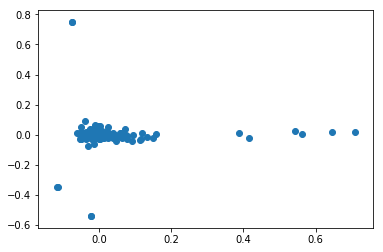

In [72]:
from sklearn.decomposition import PCA

data = tracks_by_artist_copy["normalised_vectors"].tolist()

n_components = 2
pca = PCA(n_components=n_components).fit(data)
data2D = pca.transform(data)
for idx, datum in enumerate(data2D):
    if datum[1] > 0.2 or datum[1] < -0.2 or datum[0] > 0.2:
        print(idx)
        print(datum)
        print('---------------')
plt.scatter(data2D[:,0], data2D[:,1])
plt.show()  

In [76]:
tracks_by_artist_copy.iloc[122]

artist                                                     Kendrick Lamar
album                                                 To Pimp A Butterfly
track                                                                  ​u
lyrics                  [Produced by Taz Arnold & Whoarei; Additional ...
unnormalised_vectors    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
normalised_vectors      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 123, dtype: object

In [71]:
tracks_by_artist_copy.iloc[50]

artist                                                             Eminem
album                                                     The Eminem Show
track                                                          Without Me
lyrics                  [Intro: Obie Trice]\nObie Trice! Real name, no...
unnormalised_vectors    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
normalised_vectors      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 51, dtype: object